## Aanlysis

1. Only one drug, Capomulin, amoung the four in the chart had positive effect on reduce the tumor size, and better survival rate among four. Others does not show significant difference from the placebo.
2. Metastatic Spread has a significant large standard error. More analysis is needed to proof the hypothesis for any drug is better on this aspect than others.
3. Standard error for all parameters grow with time

## Imports and Constants

In [199]:
import os
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('whitegrid', {
    'axes.edgecolor': 'black',
    'grid.color': 'lightgrey',
    }
)

# Predefined Marker, LineStyle and Colors
COLORS = ['red', 'blue', 'green', 'black']
SHARED_CONFIG = dict(linestyle='--', alpha=0.5)
DRUGS_CONFIG = OrderedDict( [
    ('Capomulin', dict(marker='o', color='red')), 
    ('Infubinol', dict(marker='^', color='blue')),
    ('Ketapril', dict(marker='s', color='green')),
    ('Placebo',  dict(marker='D', color='black'))
    ]
)
DRUGS = [x for x in DRUGS_CONFIG]


## Prepare Data

### Merge two data sets

In [200]:
df_clinical_trial = pd.read_csv(
    os.path.join('raw_data', 'clinicaltrial_data.csv')
)
df_clinical_trial.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,b128,0,45.0,0
1,f932,0,45.0,0
2,g107,0,45.0,0
3,a457,0,45.0,0
4,c819,0,45.0,0


In [201]:
df_mouse_drug = pd.read_csv(
    os.path.join('raw_data', 'mouse_drug_data.csv')
)
df_mouse_drug.head()

,Mouse ID,Drug
0,f234,Stelasyn
1,x402,Stelasyn
2,a492,Stelasyn
3,w540,Stelasyn
4,v764,Stelasyn


In [202]:
df_combo = df_clinical_trial.merge(
    df_mouse_drug,
    on='Mouse ID',
    how='outer'
)

df_combo.head()

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug
0,b128,0,45.000000,0,Capomulin
1,b128,5,45.651331,0,Capomulin
2,b128,10,43.270852,0,Capomulin
3,b128,15,43.784893,0,Capomulin
4,b128,20,42.731552,0,Capomulin


## Tumor Response to Treatement

 ### Compute Mean Values

In [203]:
df_tumor_mean = df_combo.pivot_table(
    values='Tumor Volume (mm3)',
    index='Timepoint',
    columns='Drug'
)[DRUGS]
df_tumor_mean.head()

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,45.000000,45.000000,45.000000,45.000000
5,44.266086,47.062001,47.389175,47.125589
10,43.084291,49.403909,49.582269,49.423329
15,42.064317,51.296397,52.399974,51.359742
20,40.716325,53.197691,54.920935,54.364417


### Compute Standard Error

In [204]:
df_tumor_sem = df_combo.pivot_table(
    values='Tumor Volume (mm3)',
    index='Timepoint',
    columns='Drug',
    aggfunc='sem'
)[DRUGS]

df_tumor_sem.head()

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,0.000000,0.000000,0.000000,0.000000
5,0.448593,0.235102,0.264819,0.218091
10,0.702684,0.282346,0.357421,0.402064
15,0.838617,0.357705,0.580268,0.614461
20,0.909731,0.476210,0.726484,0.839609


### Plot with pylot

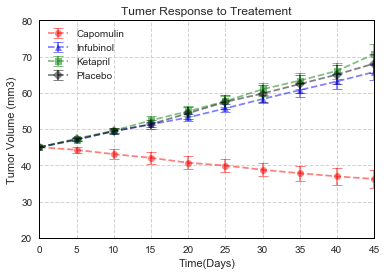

In [205]:
fig, ax = plt.subplots(figsize=(6, 4))

for drug in DRUGS:
    ax.errorbar(
       x=df_tumor_sem.index,
       y=df_tumor_mean[drug],
       yerr=df_tumor_sem[drug] * 1.96,
       capsize=5,
       capthick=1,
       **DRUGS_CONFIG[drug],
       **SHARED_CONFIG
       )

ax.legend(loc='best')

plt.xlim((0,45))
plt.ylim((20, 80))
plt.grid(True, linestyle='--')
plt.xlabel('Time(Days)')
plt.ylabel('Tumor Volume (mm3)')
plt.title('Tumer Response to Treatement')
plt.show()

### Plot with DataFrame.plot
The limit of this approach is that marker argument does not take a list, even though color take a list of colors, so only one marker can be used. If printed on a B/W printer, this could be a problem.

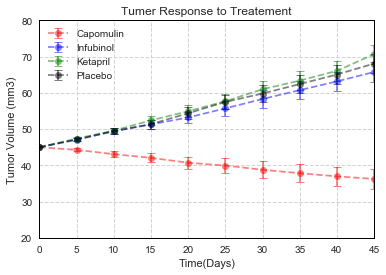

In [206]:
df_tumor_mean.plot(
    yerr=df_tumor_sem[drug] * 1.96,
    capsize=4,
    capthick=1,
    marker='o',
    color=COLORS,
    **SHARED_CONFIG,
    label='legend',
    xlim=(0, 45),
    ylim=(20, 80),
    figsize=(6,4),
    title='Tumer Response to Treatement',
    )

plt.legend(title='')
plt.grid(True, linestyle='--')
plt.xlabel('Time(Days)')
plt.ylabel('Tumor Volume (mm3)')
plt.show()

### Plot with Seaborn pointplot
Searborn's point_point() method take detail level data direclty and draw error bar automatically. Also it is highly configurable. However, I cannot figure out from the document and Googling, the way to set alpha for the line. There is an un-answered stack overflow post: https://stackoverflow.com/questions/33486613/seaborn-pointplot-aesthetics?rq=1

OK, found a work around to set line width but still no vaid on alpha: https://github.com/mwaskom/seaborn/issues/1058

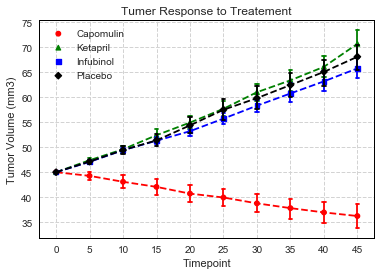

In [207]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))

 
with plt.rc_context({'lines.linewidth': 1}):
    sns.pointplot(
        x="Timepoint", 
        y="Tumor Volume (mm3)", 
        hue="Drug", 
        data=df_combo[df_combo['Drug'].isin(DRUGS)],
        palette={drug: DRUGS_CONFIG[drug]['color'] for drug in DRUGS},
        markers=[DRUGS_CONFIG[drug]['marker'] for drug in DRUGS],
        linestyles=['--' for _ in DRUGS],
        ax=ax,
        capsize=0.1,
        alpha=0.5,
   
);
ax.legend(title='')
ax.grid(True, linestyle='--')
ax.set_title('Tumer Response to Treatement')
ax.set_alpha(0.5)
plt.show()

## Metastatic Response to Treatment

### Compute Mean Values


In [208]:
df_metastatic_mean = df_combo.pivot_table(
    values='Metastatic Sites',
    index='Timepoint',
    columns='Drug'
)[DRUGS]

df_metastatic_mean.head()

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,0.000000,0.000000,0.000000,0.000000
5,0.160000,0.280000,0.304348,0.375000
10,0.320000,0.666667,0.590909,0.833333
15,0.375000,0.904762,0.842105,1.250000
20,0.652174,1.050000,1.210526,1.526316


### Compute Standard Deviations

In [209]:
df_metastatic_sem = df_combo.pivot_table(
    values='Metastatic Sites',
    index='Timepoint',
    columns='Drug',
    aggfunc='sem'
)[DRUGS]

df_metastatic_sem.head()

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,0.000000,0.000000,0.000000,0.000000
5,0.074833,0.091652,0.098100,0.100947
10,0.125433,0.159364,0.142018,0.115261
15,0.132048,0.194015,0.191381,0.190221
20,0.161621,0.234801,0.236680,0.234064


### Plot with pyplot

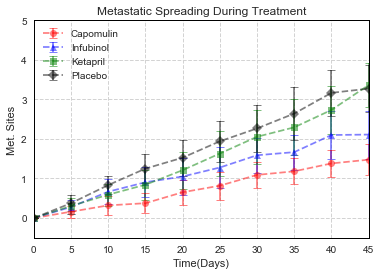

In [210]:
fig, ax = plt.subplots(figsize=(6, 4))

for drug in DRUGS:
    plt.errorbar(
       x=df_metastatic_sem.index,
       y=df_metastatic_mean[drug],
       yerr=df_metastatic_sem[drug] * 1.96,
       capsize=4,
       capthick=1,
       **DRUGS_CONFIG[drug],
       **SHARED_CONFIG
       )

ax.legend(loc='best')

plt.xlim((0, 45))
plt.ylim((-0.5, 5))
plt.grid(True, linestyle='--')
plt.xlabel('Time(Days)')
plt.ylabel('Met. Sites')
plt.title('Metastatic Spreading During Treatment')
plt.show()

### Plot with DataFrame.plot
Looks like when plotting with DataFrame the error bar size is different from the size using Pyplot. This is kind of strange. Not sure it is a bug or there is some control factor not been set correctly.

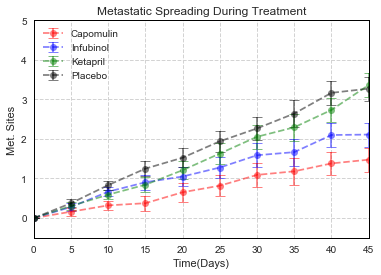

In [211]:
fig, ax = plt.subplots(figsize=(6, 4))

df_metastatic_mean.plot(
    yerr=df_metastatic_sem[drug],
    capsize=5,
    capthick=1,
    marker='o',
    color=COLORS,
    **SHARED_CONFIG,
    xlim=(0, 45),
    ylim=(-0.5, 5),
    title='Metastatic Spreading During Treatment',
    ax=ax,
)

plt.legend(title='')
plt.grid(True, linestyle='--')
plt.xlabel('Time(Days)')
plt.ylabel('Met. Sites')
plt.show()

### Plot with Seaborn pointplot

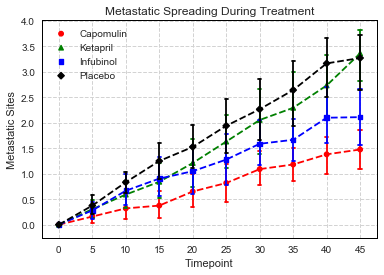

In [212]:
fig, ax = plt.subplots(figsize=(6, 4))
 
with plt.rc_context({'lines.linewidth': 1}):
    sns.pointplot(
        x="Timepoint", 
        y="Metastatic Sites", 
        hue="Drug", 
        data=df_combo[df_combo['Drug'].isin(DRUGS)],
        palette={drug: DRUGS_CONFIG[drug]['color'] for drug in DRUGS},
        markers=[DRUGS_CONFIG[drug]['marker'] for drug in DRUGS],
        linestyles=['--' for _ in DRUGS],
        ax=ax,
        capsize=0.1, 
    );

ax.legend(title='')
ax.grid(True, linestyle='--')
ax.set_title('Metastatic Spreading During Treatment')
ax.set_alpha(0.5)
plt.show()

## Survival Rates

### Computer Numbers of Survived Mice

In [213]:
df_mouse_count = df_combo.pivot_table(
    values='Mouse ID',
    index='Timepoint',
    columns='Drug',
    aggfunc='count'
)[DRUGS]

df_mouse_count.head()

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,25,25,25,25
5,25,25,23,24
10,25,21,22,24
15,24,21,19,20
20,23,20,19,19


### Compute % Survived Over Time

In [214]:
df_init_mouse_count = df_mouse_count.iloc[0]
df_mouse_perc = 100 * df_mouse_count / df_init_mouse_count
df_mouse_perc.head()

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,100.0,100.0,100.0,100.0
5,100.0,100.0,92.0,96.0
10,100.0,84.0,88.0,96.0
15,96.0,84.0,76.0,80.0
20,92.0,80.0,76.0,76.0


### Plot with Pyplot

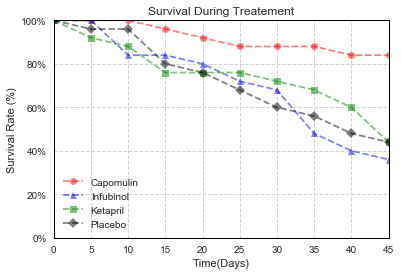

In [215]:
fig, ax = plt.subplots(figsize=(6, 4))

handles = [ plt.plot(
            df_mouse_perc[drug],
            **DRUGS_CONFIG[drug],
            **SHARED_CONFIG,
        )[0] for drug in DRUGS ]

ax.legend(
    handles=handles
)

# Set Y Axial format to percentage
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(int(x))))

plt.xlim((0, 45))
plt.ylim((0, 100))
plt.grid(True, linestyle='--')
plt.xlabel('Time(Days)')
plt.ylabel('Survival Rate (%)')
plt.title('Survival During Treatement')
plt.axis()
plt.show()

### Plot with DataFrame.plot

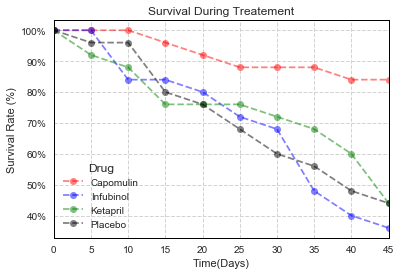

In [216]:
fig, ax = plt.subplots(figsize=(6, 4))

df_mouse_perc.reset_index().plot.line(
    x='Timepoint',
    y=DRUGS,
    marker='o',
    color=COLORS,
    **SHARED_CONFIG,
    title='Survivial Rate Over Time',
    ax=ax,
)

# Set Y Axial format to percentage
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(int(x))))
plt.title('Survival During Treatement')
plt.xlabel('Time(Days)')
plt.grid(True, linestyle='--')
plt.ylabel('Survival Rate (%)')
plt.show()

## Summary Bar Graph

### Computer Overall % Change of Tumer Volume

In [217]:
tumor_first = df_tumor_mean.iloc[0]
tumor_last = df_tumor_mean.iloc[-1]
tumor_change_perc = 100 * (tumor_last - tumor_first) / tumor_first

tumor_change_perc

Drug
Capomulin   -19.475303
Infubinol    46.123472
Ketapril     57.028795
Placebo      51.297960
dtype: float64

### Plot with Pyplot
I've tried using plot method of Series but could not get enough control over on the bar color based on positive/negative sign of the percentage, so stick to use the base Pyplot method.

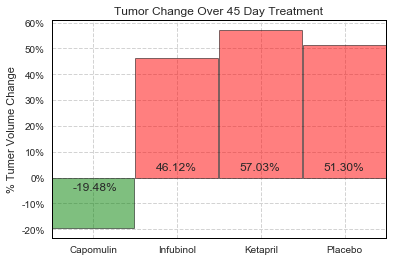

In [218]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(
    DRUGS,
    tumor_change_perc,
    align='edge',
    width=0.99,
    edgecolor='k',
    color=['g' if x < 0 else 'r' for x in tumor_change_perc],
    linewidth=1,
    alpha=0.5,
    label=None,   
)[0].axes

plt.xlim(0,4)
plt.title('Tumor Change Over 45 Day Treatment')
plt.grid(True, linestyle='--')
plt.ylabel('% Tumer Volume Change')
plt.xticks(np.arange(0.5, len(DRUGS)), rotation=0)

# Set Y Axial format to percentage
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(int(x))))

# Add labels
for i in range(len(tumor_change_perc)):
    perc = tumor_change_perc[i]
    if perc > 0:
        ax.text(i + 0.25, 3, '{:.2f}%'.format(perc))
    else:
        ax.text(i + 0.25, -5, '{:.2f}%'.format(perc))
        
plt.show()